### Counterfactuals-Decomposition
#### This file uses the parameters we calibrated from the former part and conduct counter-factuals-Decomposition. All the parameters corresponds to the first draft of the paper.

#### By Phil Huang

In [1]:
import pandas as pd
import numpy as np
import random
import copy
from matplotlib import pyplot as plt 
from copulas.datasets import sample_trivariate_xyz
from copulas.visualization import scatter_3d, compare_3d
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate
from scipy.stats import pareto, beta
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import minimize, rosen, rosen_der
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
%matplotlib inline

In [2]:
# specify the path
path  = '/Users/philhuang/Desktop/FDI/workingdata/'
figure_path = '/Users/philhuang/Desktop/FDI/figure/'

#### Type in some functions we need to solve for $\delta$ and $\eta$.

In [3]:
# Eqaution 8 where we calculate optimal beta.
def get_optimal_beta(sigma, eta):
    part1     = eta/(1-eta)
    part2     = 1-(sigma-1)*(1-eta)/sigma 
    part3     = 1- (sigma-1)*eta/sigma 
    temp      = np.sqrt(part1*part2/part3)
    beta_star = temp/(1+temp)
    return beta_star

# From (8), we solve for eta given beta. We need to use binary search.
# First, we define a function with which we get the value which is closer to the target.
# when we have two candidates RHS_vals[a]<RHS_vals[b], which means the a_th RHS value smaller than the target 
# and the b_th RHS values bigger than the target.

def get_closer_num(lst,a,b,target):
    baseline = abs(lst[a]-target)
    if abs(lst[b]-target) <= baseline:
        return b
    else:
        return a

# Then we define a binary search function to solve the function.
# In general, lst_a contains the target we want to search for, and we want to return the corresponding 
# element in lst_b
def get_ans(lst_a, lst_b, target):
    
    left=0 
    right=len(lst_a)
    
    while left<right:
        middle = left+ ((right - left)//2)
        if lst_a[middle] == target:
            return lst_b[middle]
        if lst_a[middle] < target:
            if lst_a[middle+1] >= target:
                idx_g = get_closer_num(lst_a, middle, middle+1, target)
                return lst_b[idx_g]
            else:
                left = middle+1
        if lst_a[middle] > target:
            if lst_a[middle-1] <= target:
                idx_g = get_closer_num(lst_a, middle-1, middle, target)
                return lst_b[idx_g]
            else:
                right = middle

# Equation 7. Given sigma, eta and beta, we get delta. 
# Note that since beta* is a function of sigma and eta, delta is a function of sigma and eta too. 
def get_delta(sigma, eta, beta):
    part1 = sigma - (sigma-1)*(beta*eta+(1-beta)*(1-eta))
    part2 = (((1/beta)**eta) * ((1/(1-beta))**(1-eta)))**(1-sigma)
    delta = part1*part2
    return delta

# define a function to calculate omega used in the counterfactuals.
def get_Omega(sigma, eta, beta):
    part1 = (1/beta)**eta
    part2 = (1/(1-beta))**(1-eta)
    Omega = (part1*part2)**(1-sigma)
    return Omega

# Input equation (15-19)
def get_FirmVar(beta, eta, sigma, wh, wm, tau, varphi, P, X, bunch_or_not, cost):
    
    p_star  = (sigma/(sigma-1))* ((wh/eta)**eta) * ((wm/(1-eta))**(1-eta)) /varphi
    p_tild  = (sigma/(sigma-1)) * (wh/(beta*eta))**eta * (wm/((1-beta)*(1-eta)))**(1-eta) / varphi
    x_tild  = p_tild**(1-sigma) * P**(sigma-1) * X * (1-tau)**sigma
    h_tild  = ((sigma-1)/sigma) * (beta*eta/wh) * x_tild
    m_tild  = ((sigma-1)/sigma) * ((1-beta)*(1-eta)/wm) * x_tild
    
    # Note that if ther is no bunching (bunch_or_not == 1), the final Pi is just Pi_tild.
    # If there is bunching (bunch_or_not == 0), then the final Pi should deduct the cost.
    pi_tild = (get_delta(sigma, eta, beta)-cost*(1-bunch_or_not))* p_star**(1-sigma) * P**(sigma-1)* X*((1-tau)**sigma)/sigma

    return p_tild, x_tild, h_tild, m_tild, pi_tild
    #return pi_tild

# Calculate mean of the variable.
def get_meanVarByBin(df_name, group_id, grouped_var):
    rst = df_name.groupby(group_id)[grouped_var].mean().reset_index()
    return rst[group_id].values, rst[grouped_var].values


### P1. Generate distribution of intensity and productivity we need.

In [4]:
# We read in bins (beta), eta data and see their distributions. 
beta_eta_df   = pd.read_csv(path+'beta_eta.csv')
beta_all      = np.array(beta_eta_df['beta_bins'])
eta_all       = np.array(beta_eta_df['eta_bins'])

# Read in bins, real distribution and counterfactual distributions of firms we use in the bunching estimation.
bunching_df   = pd.read_excel(path+'R2_pre2008June122023.xlsx')
bunching_df

bins_bunching = np.array(bunching_df['R2_bins'])
C_bunching    = np.array(bunching_df['R2_C_all'])  # Actual probability of firms falling into each bins.
h_bunching    = np.array(bunching_df['h'])         # Counterfactual probability of firms falling into each bins.

bunching_para = pd.read_excel(path+'R4_pre2008June122023.xlsx')
p             = np.int32(np.array(bunching_para['p'])[0])                                 # Polynomial.
minD          = np.float64(np.array(bunching_para['minD'])[0])                             # Minimum of the bins we use.

tau_L         = np.float64(0.15)
tau_H         = np.float64(0.225)

w_h           = 1
w_m           = 1
big_p         = 1
big_x         = 1

# Read in the parameters we calibrated.
final_paras = pd.read_csv(path+'calibration_rstJune122023.csv')
sigma, theta, k, mu_c = np.array(final_paras)[0,:]
print(sigma, theta, k, mu_c)

# Read in b that we estimated from the bunching part.
b = np.array(pd.read_excel(path+'R5_pre2008June122023.xlsx')['b'])


2.346160352519226 20.05298080521329 2.151907030827452 0.3203391475285694


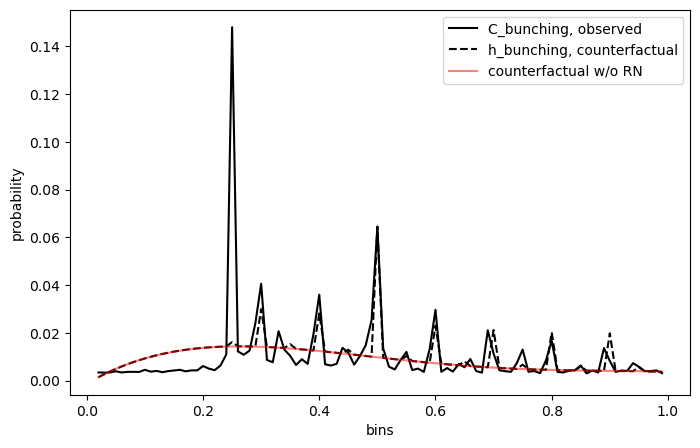

In [5]:
# Now we want to get the distribution of eta. 
# In order to do so, we omit all the round number effects. 
polynomial_beta = []
for i in range(p+1):
    polynomial_beta.append(bins_bunching**i)
polynomial_beta = np.array(polynomial_beta).T

# Multiply b and polynomial_beta together.
distribution_noRN = np.dot(polynomial_beta, b[:p+1].reshape(p+1,-1))
distribution_noRN = distribution_noRN.ravel()

# Plot the distribution.
fig1, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.plot(bins_bunching, C_bunching, linestyle='solid', c='k', linewidth=1.5, label='C_bunching, observed')
ax.plot(bins_bunching, h_bunching, linestyle='--', c='k', linewidth=1.5, label='h_bunching, counterfactual')
ax.plot(bins_bunching, distribution_noRN, linestyle='solid', alpha=0.5, c='r', 
        linewidth=1.5, label='counterfactual w/o RN')
ax.set(xlabel='bins', ylabel='probability')
ax.legend()

In [6]:
# Read in b that we estimated from the bunching part.
b = np.array(pd.read_excel(path+'outputJune122023/R5_pre2008June122023.xlsx')['b'])

# Now we want to get the distribution of eta, and try to fit it to a beta-distribution. 
# In order to do so, we omit all the round number effects. 
polynomial_beta = []
for i in range(p+1):
    polynomial_beta.append(bins_bunching**i)
polynomial_beta = np.array(polynomial_beta).T

# Multiply b and polynomial_beta together.
distribution_noRN = np.dot(polynomial_beta, b[:p+1].reshape(p+1,-1))
distribution_noRN = distribution_noRN.ravel()

# Now we simulate 100,000 firms. 
# The first step is to generate 100,000 betas according to the counterfactual distribution of Beta.
# Now we know the probability of etas falling into each bins, we simulate data of eta based on this.
# cf means counterfactual here.
beta_cf_simul = []

# We cut the last bin (0.99-1) out since there would be a lot of extrem values in that bin when we calculate eta.
bins_bunching = np.array(bunching_df['R2_bins'])

# We get lower and uppper bond of each bin, and sample beta within each bin.
beta_temp  = list(bins_bunching)
beta_temp.append(np.float64(1.0))
total_firm_num = 100000

for i in range(len(beta_temp)-1):
    lb_bin  = beta_temp[i]     # lower bond of the bin
    ub_bin  = beta_temp[i+1]   # upper bond of the bin 
    len_bin = ub_bin-lb_bin
    
    # Number of firms in each bin, each should have an beta that lies within the range of the bin. 
    # Here we assume that in each bin, beta is uniformly distributed.
    bin_firm_num = int(h_bunching[i]*total_firm_num)
    np.random.seed(123+i)
    
    # Random.random_sample generates uniformly-distributed sample in [0,1). So here we need to multiply them
    # by the length of each bin, and add lb_bin to it. 
    rand_uniform   = np.random.random_sample(size = bin_firm_num)
    beta_each_bin  = list(rand_uniform*len_bin + lb_bin)
    beta_cf_simul += beta_each_bin

# Now we put all the simulated_beta_star into each bins.
bins_temp = np.arange(2,101)/100

# Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
simul_bin_id = np.digitize(beta_cf_simul, bins_temp, right=False)

# Count how many betas are there in each bin.
simul_beta_df      = pd.DataFrame(data={'beta_cf_simul':np.array(beta_cf_simul), 
                                        'simul_bin_id':np.array(simul_bin_id)+1})
simul_betaCount_df = simul_beta_df.groupby('simul_bin_id')['beta_cf_simul'].count().reset_index()
simul_betaCount_df.rename(columns={'beta_cf_simul':'count'}, inplace=True)

# Count the number of firms that may choose to bunch (FDI_SAHRE<25)
num_possible_bunchFirm = np.sum(simul_betaCount_df[simul_betaCount_df['simul_bin_id']<25]['count'])

# Let's check how our simulated beta looks like. 
a1 = len(beta_cf_simul)
a2 = int(np.sum(h_bunching)*total_firm_num)
print('Number of simulated firms: {0}'.format(a1))
print('Number of counterfactual firms: {0}'.format(a2))
print('Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.')
print('There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.')



Number of simulated firms: 99277
Number of counterfactual firms: 99321
Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.
There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.


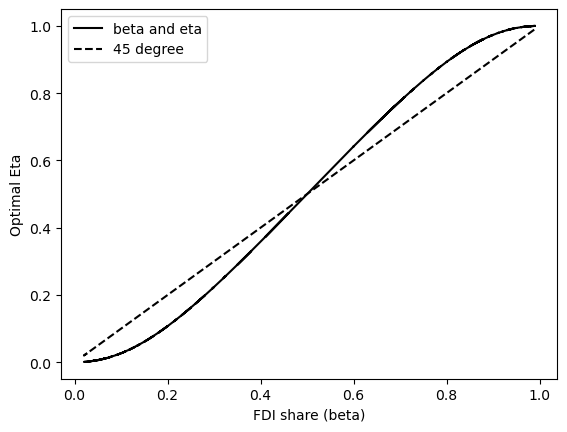

In [7]:
# Now we calculate optimal eta for these firms.
# With beta_bins, calculate the LHS of (8). This is the list of targets we are searching for. 
# Note that now when beta>0.99, there would be extreme values when we calculate eta. For simplicity, we replace
# all beta>0.99 to be 0.99.
simul_beta_df.loc[simul_beta_df['beta_cf_simul']>0.99, ['beta_cf_simul']]=0.99
beta_cf_simul = simul_beta_df['beta_cf_simul'].values
LHS_8 = np.array(beta_cf_simul)/(1-np.array(beta_cf_simul))

# Define the space of eta, which is the lst_b in the get_ans function. 
eta_space = np.linspace(0.0001, 0.9999, 1000000)

# Calculate the RHS of equation 8, which is the lst_a in the get_ans function. 
part1  = eta_space/(1-eta_space)
part2  = 1-(sigma-1)*(1-eta_space)/sigma 
part3  = 1- (sigma-1)*eta_space/sigma 
RHS_8  = np.sqrt(part1*part2/part3)

eta_simul = np.zeros(len(beta_cf_simul))
    
for i in range(len(beta_cf_simul)): 
    eta_simul[i] = get_ans(RHS_8, eta_space, LHS_8[i])

simul_beta_df['eta_simul'] = np.array(eta_simul)

# Let's see the relationship between beta and eta.
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['eta_simul'], c='k', linestyle='-', label='beta and eta')
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['beta_cf_simul'], c='k', linestyle='--', label='45 degree')
plt.xlabel('FDI share (beta)')
plt.ylabel('Optimal Eta')
plt.legend()

### P2. Generate correlated cost c and varphi using copula.

In [8]:
# See the process of drawing these random numbers in 
# section B.1 Online Appendix of James & Ariell (2015 CJE)
np.random.seed(1234)
copula_u = np.random.uniform(0,1,101310)

np.random.seed(123)
copula_x = np.random.uniform(0,1,101310)

copula_a = copula_x*(1-copula_x)
copula_b = theta + copula_a*((theta-1)**2)
copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

# We assume that cost is a uniform distribution.
copula_cost = copula_u*mu_c

# Now we generate varphi based on U we draw.
# If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
xm = 1

copula_varphi = xm*((1-copula_v)**(-1/k))

cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

# Winsorize the sample. Drop the bottom 1% and top 1% sample.
top99   = np.quantile(copula_varphi, 0.99)
bottom1 = np.quantile(copula_varphi, 0.01)

eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
eta_varphi_winsorized.reset_index(drop=True, inplace=True)
costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

# Compile data into a dataFrame
sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                 'simul_bin_id': simul_beta_df['simul_bin_id'],
                                 'eta_simul': simul_beta_df['eta_simul'],
                                 'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                 'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

# Compile tax rate before bunching. 
sim_firm_df['tau_noBunch'] = tau_L
sim_firm_df.loc[sim_firm_df['beta_cf_simul']<0.25, ['tau_noBunch']] = tau_H

# Outcomes without bunching (NB means no bunching).
p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                   sigma, w_h, w_m, 
                                                   sim_firm_df['tau_noBunch'],
                                                   sim_firm_df['varphi_simul'], 
                                                   big_p, big_x, 
                                                   1, 0)

# Take logs.
sim_firm_df['p_NB'] = np.log(p_NB)
sim_firm_df['x_NB'] = np.log(x_NB)
sim_firm_df['h_NB'] = np.log(h_NB)
sim_firm_df['m_NB'] = np.log(m_NB)
sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)
# Calculate pre-tax profit.
sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))

sim_firm_df


,beta_cf_simul,simul_bin_id,eta_simul,cost_simul,varphi_simul,tau_noBunch,p_NB,x_NB,h_NB,m_NB,pi_postTaxNB,pi_preTax_NB
0,0.026965,2,0.001793,0.061351,1.183801,0.225,0.433685,-1.181827,-11.674631,-1.766480,-1.996751,-1.741859
1,0.022861,2,0.001280,0.199286,1.392891,0.225,0.261878,-0.950548,-11.945456,-1.530479,-1.771423,-1.516531
2,0.022269,2,0.001213,0.140221,1.192041,0.225,0.416320,-1.158451,-12.233397,-1.737708,-1.980181,-1.725289
3,0.025513,2,0.001601,0.251581,2.006429,0.225,-0.097254,-0.467099,-11.128497,-1.050069,-1.284136,-1.029243
4,0.027195,2,0.001824,0.249857,2.285942,0.225,-0.223836,-0.296699,-10.763867,-0.881619,-1.111288,-0.856395
...,...,...,...,...,...,...,...,...,...,...,...,...
99272,0.990000,99,0.999761,0.261104,1.165690,0.150,0.415591,-0.940747,-1.506560,-14.440604,-1.779844,-1.617325
99273,0.990000,99,0.999761,0.069244,1.137314,0.150,0.440235,-0.973922,-1.539735,-14.473779,-1.813020,-1.650501
99274,0.990000,99,0.999761,0.156042,1.230591,0.150,0.361410,-0.867811,-1.433624,-14.367667,-1.706908,-1.544389
99275,0.990000,99,0.999761,0.051548,1.101597,0.150,0.472143,-1.016875,-1.582689,-14.516732,-1.855973,-1.693454


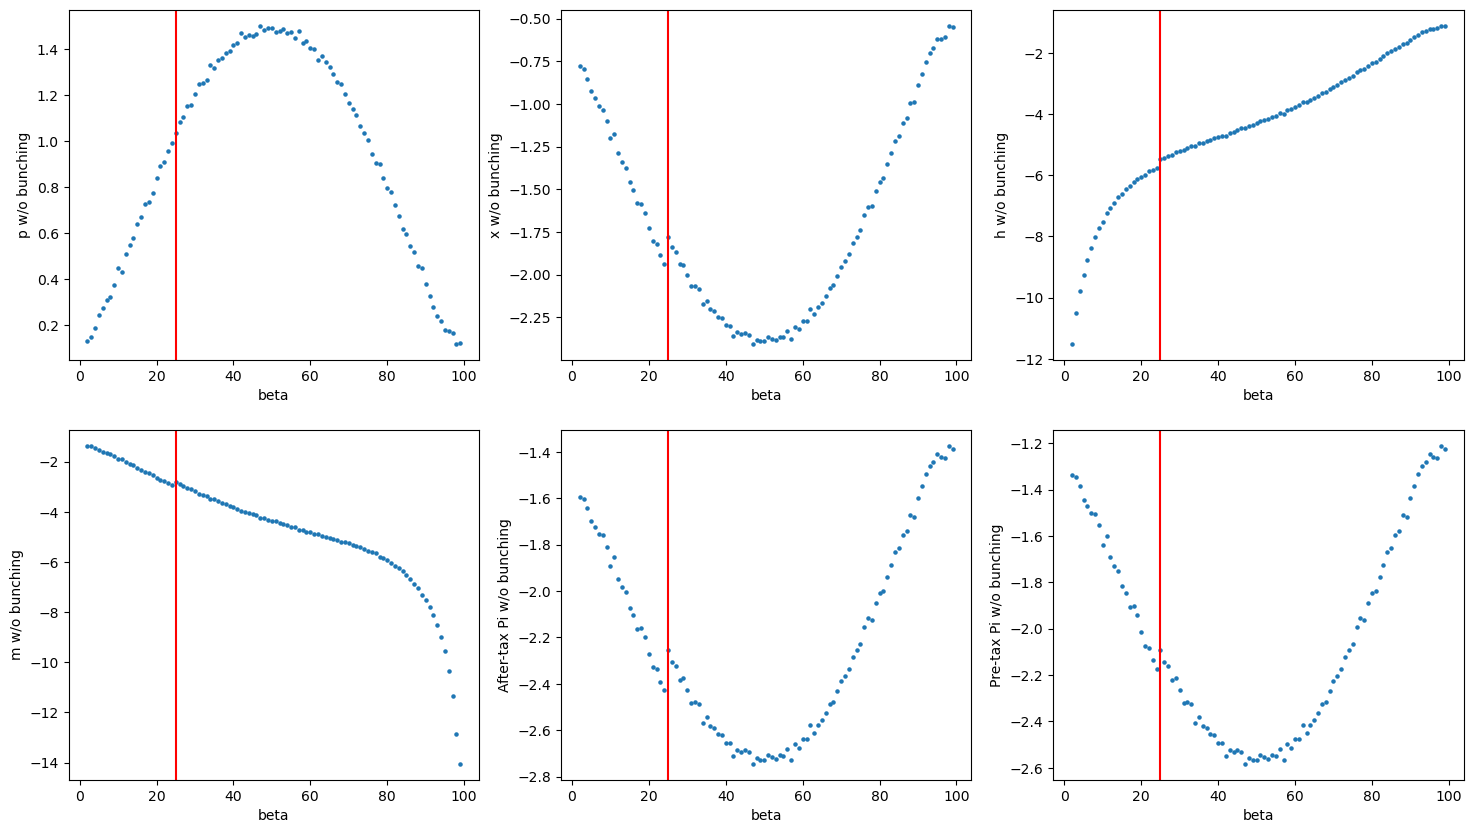

In [9]:
# Visualize the distribution of outcomes without bunching.

bin_p, mean_p_NB           = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'p_NB')
bin_x, mean_x_NB           = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'x_NB')
bin_h, mean_h_NB           = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'h_NB')
bin_m, mean_m_NB           = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'm_NB')
bin_pi1, mean_piPostTax_NB = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'pi_postTaxNB')
bin_pi2, mean_piPreTax_NB  = get_meanVarByBin(sim_firm_df, 'simul_bin_id', 'pi_preTax_NB')

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18,10))
ax1.scatter(bin_p, mean_p_NB, s=5)
ax1.set(xlabel='beta', ylabel='p w/o bunching')
ax1.axvline(x=25, c='r')

ax2.scatter(bin_x, mean_x_NB, s=5)
ax2.set(xlabel='beta', ylabel='x w/o bunching')
ax2.axvline(x=25, c='r')

ax3.scatter(bin_h, mean_h_NB, s=5)
ax3.set(xlabel='beta', ylabel='h w/o bunching')
ax3.axvline(x=25, c='r')

ax4.scatter(bin_m, mean_m_NB, s=5)
ax4.set(xlabel='beta', ylabel='m w/o bunching')
ax4.axvline(x=25, c='r')

ax5.scatter(bin_pi1, mean_piPostTax_NB, s=5)
ax5.set(xlabel='beta', ylabel='After-tax Pi w/o bunching')
ax5.axvline(x=25, c='r')

ax6.scatter(bin_pi2, mean_piPreTax_NB, s=5)
ax6.set(xlabel='beta', ylabel='Pre-tax Pi w/o bunching')
ax6.axvline(x=25, c='r')

In [10]:
# Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
# Calculate the rhs of equation 7 

part1 = get_delta(sigma, sim_firm_df['eta_simul'], 0.25)-sim_firm_df['cost_simul']
part2 = ((1-tau_L)/(1-tau_H))**sigma
RHS   = part1*part2

# Calculate the LHS of equation (7). 
LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

# compile bunching decision into the dataframe
sim_firm_df['bunch_decision'] = bunch_decision

# When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=0.25, ['bunch_decision']]=1

# When sim_firm_df['beta_cf_simul']<=0.07, there is no bunching.
#sim_firm_df.loc[sim_firm_df['beta_cf_simul']<=0.07, ['bunch_decision']]=1

# Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
# When there is bunching, final_beta = 0.25.
sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
sim_firm_df.loc[sim_firm_df['bunch_decision']==0, ['final_beta']] = np.float32(0.25)

# Calculate final_bin_ID.
# Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

# Note that eta does not change, so final_eta = eta_simul
sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

# Final Tax rate.
sim_firm_df['final_tau'] = tau_H
sim_firm_df.loc[sim_firm_df['final_beta']>=0.25, ['final_tau']]=tau_L

In [11]:
# Outcomes with bunching.
final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                             sigma, w_h, w_m, 
                                                             sim_firm_df['final_tau'],
                                                             sim_firm_df['varphi_simul'], 
                                                             big_p, big_x, 
                                                             sim_firm_df['bunch_decision'], 
                                                             sim_firm_df['cost_simul'])
# Compile things. 
sim_firm_df['final_p']          = np.log(final_p)
sim_firm_df['final_x']          = np.log(final_x)
sim_firm_df['final_h']          = np.log(final_h)
sim_firm_df['final_m']          = np.log(final_m)
sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

In [12]:
sim_firm_df[sim_firm_df['bunch_decision']==0]

,beta_cf_simul,simul_bin_id,eta_simul,cost_simul,varphi_simul,tau_noBunch,p_NB,x_NB,h_NB,m_NB,...,final_beta,final_bin_id,final_eta,final_tau,final_p,final_x,final_h,final_m,final_pi_PostTax,final_pi_PreTax
0,0.026965,2,0.001793,0.061351,1.183801,0.225,0.433685,-1.181827,-11.674631,-1.766480,...,0.25,25,0.001793,0.15,0.689573,-1.309571,-9.575442,-2.154571,-1.941499,-1.778980
5,0.024231,2,0.001441,0.087322,1.153799,0.225,0.453183,-1.208075,-12.026322,-1.789570,...,0.25,25,0.001441,0.15,0.712594,-1.340562,-9.824983,-2.185209,-2.003867,-1.841348
6,0.029808,2,0.002201,0.088562,2.353703,0.225,-0.246877,-0.265682,-10.453229,-0.853669,...,0.25,25,0.002201,0.15,0.005297,-0.388427,-8.449278,-1.233835,-1.052946,-0.890427
17,0.021755,2,0.001157,0.004411,1.007211,0.225,0.583714,-1.383791,-12.529355,-1.962467,...,0.25,25,0.001157,0.15,0.846270,-1.520510,-10.224435,-2.364874,-2.087502,-1.924983
22,0.027245,2,0.001831,0.024148,1.110188,0.225,0.498530,-1.269119,-11.730625,-1.854098,...,0.25,25,0.001831,0.15,0.754055,-1.396375,-9.641274,-2.241413,-1.985170,-1.822652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22924,0.249962,24,0.162412,0.039330,1.222064,0.225,1.264722,-2.300536,-6.060125,-3.320921,...,0.25,25,0.162412,0.15,1.264739,-2.083837,-5.843276,-3.104272,-2.620204,-2.457686
22927,0.240234,24,0.151115,0.115303,1.204695,0.225,1.242674,-2.270856,-6.142236,-3.264956,...,0.25,25,0.151115,0.15,1.247634,-2.060811,-5.892344,-3.067849,-2.709928,-2.547409
22928,0.240202,24,0.151078,0.095011,1.246866,0.225,1.208144,-2.224374,-6.096134,-3.218388,...,0.25,25,0.151078,0.15,1.213123,-2.014353,-5.846131,-3.021347,-2.633450,-2.470931
22931,0.242113,24,0.153278,0.104352,1.238537,0.225,1.222075,-2.243128,-6.092508,-3.242254,...,0.25,25,0.153278,0.15,1.226020,-2.031715,-5.849038,-3.041303,-2.663838,-2.501319


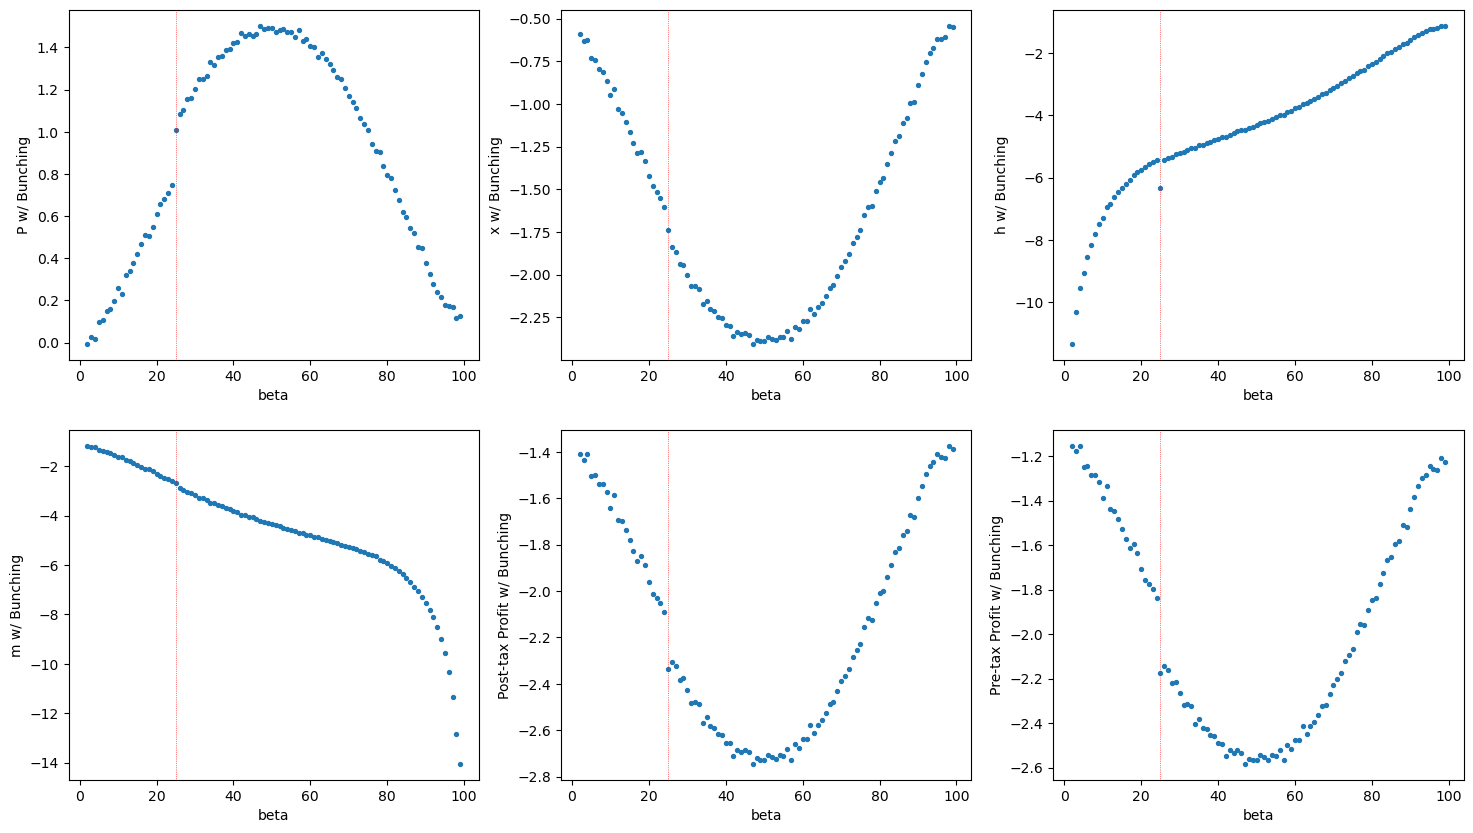

In [13]:
# Visualize the distribution of outcomes after bunching.

bin_p, mean_p_B           = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_p')
bin_x, mean_x_B           = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_x')
bin_h, mean_h_B           = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_h')
bin_m, mean_m_B           = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_m')
bin_pi1, mean_piPostTax_B = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_pi_PostTax')
bin_pi2, mean_piPreTax_B  = get_meanVarByBin(sim_firm_df, 'final_bin_id', 'final_pi_PreTax')

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18,10))
ax1.scatter(bin_p, mean_p_B, s=8)
ax1.set(xlabel='beta', ylabel='P w/ Bunching')
ax1.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

ax2.scatter(bin_x, mean_x_B, s=8)
ax2.set(xlabel='beta', ylabel='x w/ Bunching')
ax2.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

ax3.scatter(bin_h, mean_h_B, s=8)
ax3.set(xlabel='beta', ylabel='h w/ Bunching')
ax3.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

ax4.scatter(bin_m, mean_m_B, s=8)
ax4.set(xlabel='beta', ylabel='m w/ Bunching')
ax4.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

ax5.scatter(bin_pi1, mean_piPostTax_B, s=8)
ax5.set(xlabel='beta', ylabel='Post-tax Profit w/ Bunching')
ax5.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

ax6.scatter(bin_pi2, mean_piPreTax_B, s=8)
ax6.set(xlabel='beta', ylabel='Pre-tax Profit w/ Bunching')
ax6.axvline(x=25, c='r', linewidth=0.5, linestyle=':')

In [14]:
# Now we take out the firms that choose to bunch.
bunched_firms = copy.deepcopy(sim_firm_df[sim_firm_df['bunch_decision']==0])
bunched_firms

,beta_cf_simul,simul_bin_id,eta_simul,cost_simul,varphi_simul,tau_noBunch,p_NB,x_NB,h_NB,m_NB,...,final_beta,final_bin_id,final_eta,final_tau,final_p,final_x,final_h,final_m,final_pi_PostTax,final_pi_PreTax
0,0.026965,2,0.001793,0.061351,1.183801,0.225,0.433685,-1.181827,-11.674631,-1.766480,...,0.25,25,0.001793,0.15,0.689573,-1.309571,-9.575442,-2.154571,-1.941499,-1.778980
5,0.024231,2,0.001441,0.087322,1.153799,0.225,0.453183,-1.208075,-12.026322,-1.789570,...,0.25,25,0.001441,0.15,0.712594,-1.340562,-9.824983,-2.185209,-2.003867,-1.841348
6,0.029808,2,0.002201,0.088562,2.353703,0.225,-0.246877,-0.265682,-10.453229,-0.853669,...,0.25,25,0.002201,0.15,0.005297,-0.388427,-8.449278,-1.233835,-1.052946,-0.890427
17,0.021755,2,0.001157,0.004411,1.007211,0.225,0.583714,-1.383791,-12.529355,-1.962467,...,0.25,25,0.001157,0.15,0.846270,-1.520510,-10.224435,-2.364874,-2.087502,-1.924983
22,0.027245,2,0.001831,0.024148,1.110188,0.225,0.498530,-1.269119,-11.730625,-1.854098,...,0.25,25,0.001831,0.15,0.754055,-1.396375,-9.641274,-2.241413,-1.985170,-1.822652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22924,0.249962,24,0.162412,0.039330,1.222064,0.225,1.264722,-2.300536,-6.060125,-3.320921,...,0.25,25,0.162412,0.15,1.264739,-2.083837,-5.843276,-3.104272,-2.620204,-2.457686
22927,0.240234,24,0.151115,0.115303,1.204695,0.225,1.242674,-2.270856,-6.142236,-3.264956,...,0.25,25,0.151115,0.15,1.247634,-2.060811,-5.892344,-3.067849,-2.709928,-2.547409
22928,0.240202,24,0.151078,0.095011,1.246866,0.225,1.208144,-2.224374,-6.096134,-3.218388,...,0.25,25,0.151078,0.15,1.213123,-2.014353,-5.846131,-3.021347,-2.633450,-2.470931
22931,0.242113,24,0.153278,0.104352,1.238537,0.225,1.222075,-2.243128,-6.092508,-3.242254,...,0.25,25,0.153278,0.15,1.226020,-2.031715,-5.849038,-3.041303,-2.663838,-2.501319


In [15]:
# Calculate the change in profit.
# Overall change in profit.
change_profit = np.mean(bunched_firms['final_pi_PostTax'] - bunched_firms['pi_postTaxNB'])

# Calculate the delta(beta*) - delta(\underlined_{\beta}) (efficiency loss for profits)
# First, without adjustment cost.
effLoss_profit_noCost = np.mean(np.log(get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])/
                                       get_delta(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

# With adjustment cost.
effLoss_profit_Cost = np.mean(np.log((get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])
                                     -bunched_firms['cost_simul'])/
                                     get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])))

# Gain in profit because of benefit.
gain_profit = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

print((change_profit, effLoss_profit_noCost, effLoss_profit_Cost, gain_profit))
print(effLoss_profit_Cost+effLoss_profit_noCost+gain_profit)

(0.09859068691201935, -0.024697717461794586, -0.09343421694813972, 0.21672262132195358)
0.09859068691201928


In [16]:
# Calculate the change in sales.
# Overall change in sales.
change_sales = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

# Calculate the change in Omega (efficiency loss for output)
effLoss_sales = np.mean(np.log(get_Omega(sigma, bunched_firms['final_eta'], bunched_firms['final_beta']))
                        -np.log(get_Omega(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))
                         
# Gain in profit because of benefit.
gain_sales = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

print((change_sales, effLoss_sales, gain_sales))
print(effLoss_sales+gain_sales)

(0.11220504504582936, -0.10451757627612424, 0.21672262132195358)
0.11220504504582934


In [17]:
# Calculate the change in h 
# Overall change in h.
change_h = np.mean(bunched_firms['final_h']-bunched_firms['h_NB'])

# First is the change of ownership share.
betaChange_h = np.mean(np.log(bunched_firms['final_beta'])-np.log(bunched_firms['beta_cf_simul']))

# First is the change of output scale.
Xchange_h = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

print((change_h, betaChange_h, Xchange_h))
print(betaChange_h + Xchange_h)

(0.6045266653749203, 0.49232162032909094, 0.11220504504582936)
0.6045266653749203


In [18]:
# Calculate the change in m 
# Overall change in m.
change_m = np.mean(bunched_firms['final_m']-bunched_firms['m_NB'])

# First is the change of ownership share.
betaChange_m = np.mean(np.log(1-bunched_firms['final_beta'])-np.log(1-bunched_firms['beta_cf_simul']))

# First is the change of output scale.
Xchange_m = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

print((change_m, betaChange_m, Xchange_m))
print(betaChange_m + Xchange_m)

(0.007127024896520226, -0.10507802014930906, 0.11220504504582936)
0.007127024896520298


### We pack things above to be a big function

In [19]:

def DecomposeOutcomeChange(theta, mu_c, k, Reps):
    # See the process of drawing these random numbers in 
    # section B.1 Online Appendix of James & Ariell (2015 CJE)
    np.random.seed(1234+Reps)
    copula_u = np.random.uniform(0,1,101310)

    np.random.seed(123+Reps)
    copula_x = np.random.uniform(0,1,101310)

    copula_a = copula_x*(1-copula_x)
    copula_b = theta + copula_a*((theta-1)**2)
    copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
    copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
    copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

    # We assume that cost is just a uniform distribution.
    copula_cost = copula_u*mu_c

    # Now we generate varphi based on U we draw.
    # If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
    xm = 1

    copula_varphi = xm*((1-copula_v)**(-1/k))

    cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

    # Winsorize the sample. Drop the bottom 1% and top 1% sample.
    top99   = np.quantile(copula_varphi, 0.99)
    bottom1 = np.quantile(copula_varphi, 0.01)

    eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
    eta_varphi_winsorized.reset_index(drop=True, inplace=True)
    costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

    # Compile data into a dataFrame
    sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                     'simul_bin_id': simul_beta_df['simul_bin_id'],
                                     'eta_simul': simul_beta_df['eta_simul'],
                                     'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                     'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

    # Compile tax rate before bunching. 
    sim_firm_df['tau_noBunch'] = tau_L
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']<0.25, ['tau_noBunch']] = tau_H

    # Outcomes without bunching (NB means no bunching).
    p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                       sigma, w_h, w_m, 
                                                       sim_firm_df['tau_noBunch'],
                                                       sim_firm_df['varphi_simul'], 
                                                       big_p, big_x, 
                                                       1, 0)

    # Take logs.
    sim_firm_df['p_NB'] = np.log(p_NB)
    sim_firm_df['x_NB'] = np.log(x_NB)
    sim_firm_df['h_NB'] = np.log(h_NB)
    sim_firm_df['m_NB'] = np.log(m_NB)
    sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)
    
    # Calculate pre-tax profit.
    sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))
    
    # cost and scale
    costscale_corr = np.corrcoef(sim_firm_df['x_NB'], sim_firm_df['cost_simul'])[0][1]


    # Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
    # Calculate the rhs of equation 7 

    part1 = get_delta(sigma, sim_firm_df['eta_simul'], 0.25)-sim_firm_df['cost_simul']
    part2 = ((1-tau_L)/(1-tau_H))**sigma
    RHS   = part1*part2

    # Calculate the LHS of equation (7). 
    LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
    bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

    # compile bunching decision into the dataframe
    sim_firm_df['bunch_decision'] = bunch_decision

    # When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=0.25, ['bunch_decision']]=1

    # When sim_firm_df['beta_cf_simul']<=0.07, there is no bunching.
    #sim_firm_df.loc[sim_firm_df['beta_cf_simul']<=0.07, ['bunch_decision']]=1


    # Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
    # When ther is bunching, final_beta = 0.25.
    sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
    sim_firm_df.loc[sim_firm_df['bunch_decision']==0, ['final_beta']] = np.float32(0.25)

    # Calculate final_bin_ID.
    # Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
    sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
    sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

    # Note that eta does not change, so final_eta = eta_simul
    sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

    # Final Tax rate.
    sim_firm_df['final_tau'] = tau_H
    sim_firm_df.loc[sim_firm_df['final_beta']>=0.25, ['final_tau']]=tau_L

    # Outcomes with bunching.
    final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                                 sigma, w_h, w_m, 
                                                                 sim_firm_df['final_tau'],
                                                                 sim_firm_df['varphi_simul'], 
                                                                 big_p, big_x, 
                                                                 sim_firm_df['bunch_decision'], 
                                                                 sim_firm_df['cost_simul'])
    # Compile things. 
    sim_firm_df['final_p']          = np.log(final_p)
    sim_firm_df['final_x']          = np.log(final_x)
    sim_firm_df['final_h']          = np.log(final_h)
    sim_firm_df['final_m']          = np.log(final_m)
    sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
    sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

    # Now we take out the firms that choose to bunch.
    bunched_firms = copy.deepcopy(sim_firm_df[sim_firm_df['bunch_decision']==0])

    # Calculate the change in profit.
    # Overall change in profit.
    change_profit = np.mean(bunched_firms['final_pi_PostTax'] - bunched_firms['pi_postTaxNB'])

    # Calculate the delta(beta*) - delta(\underlined_{\beta}) (efficiency loss for profits)
    # First, without adjustment cost.
    effLoss_profit_noCost = np.mean(np.log(get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])/
                                           get_delta(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

    # With adjustment cost.
    effLoss_profit_Cost = np.mean(np.log((get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])
                                         -bunched_firms['cost_simul'])/
                                         get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])))

    # Gain in profit because of benefit.
    gain_profit = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

    # Calculate the change in output.
    # Overall change in output.
    change_sales = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    # Calculate the change in Omega (efficiency loss for output)
    effLoss_sales = np.mean(np.log(get_Omega(sigma, bunched_firms['final_eta'], bunched_firms['final_beta']))
                             -np.log(get_Omega(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

    # Gain in profit because of benefit.
    gain_sales = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

    # Calculate the change in h 
    # Overall change in h.
    change_h = np.mean(bunched_firms['final_h']-bunched_firms['h_NB'])

    # First is the change of ownership share.
    betaChange_h = np.mean(np.log(bunched_firms['final_beta'])-np.log(bunched_firms['beta_cf_simul']))

    # First is the change of output scale.
    Xchange_h = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    # Calculate the change in m 
    # Overall change in m.
    change_m = np.mean(bunched_firms['final_m']-bunched_firms['m_NB'])

    # First is the change of ownership share.
    betaChange_m = np.mean(np.log(1-bunched_firms['final_beta'])-np.log(1-bunched_firms['beta_cf_simul']))

    # First is the change of output scale.
    Xchange_m = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    rst = [change_profit, effLoss_profit_noCost, effLoss_profit_Cost, gain_profit, 
           change_sales, effLoss_sales, gain_sales, 
           change_h, betaChange_h, Xchange_h, 
           change_m, betaChange_m, Xchange_m,
           costscale_corr]
    
    return rst


In [20]:
decompose_reps = 1000
decompose_rst = np.zeros((decompose_reps, 14))

for i in range(1, decompose_reps+1):
    decompose_rst[i-1] = DecomposeOutcomeChange(theta, mu_c, k, i)
    if i%50 == 0:
        print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [21]:
decompose_rst.mean(0)

array([ 0.09782605, -0.02484645, -0.09405011,  0.21672262,  0.1116326 ,
       -0.10509002,  0.21672262,  0.60684349,  0.49521089,  0.1116326 ,
        0.00606023, -0.10557237,  0.1116326 ,  0.51770777])

In [22]:
np.around(decompose_rst.std(0),3)

array([0.001, 0.   , 0.001, 0.   , 0.001, 0.001, 0.   , 0.003, 0.003,
       0.001, 0.001, 0.   , 0.001, 0.002])

In [26]:
# Get the distribution of outcomes.
def Get_DistributionofOutcomes(theta, mu_c, k, Reps):
    
    # See the process of drawing these random numbers in 
    # section B.1 Online Appendix of James & Ariell (2015 CJE)
    np.random.seed(1234+Reps)
    copula_u = np.random.uniform(0,1,101310)

    np.random.seed(123+Reps)
    copula_x = np.random.uniform(0,1,101310)

    copula_a = copula_x*(1-copula_x)
    copula_b = theta + copula_a*((theta-1)**2)
    copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
    copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
    copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

    # We assume that cost is just a uniform distribution.
    copula_cost = copula_u*mu_c

    # Now we generate varphi based on U we draw.
    # If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
    xm = 1

    copula_varphi = xm*((1-copula_v)**(-1/k))

    cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

    # Winsorize the sample. Drop the bottom 1% and top 1% sample.
    top99   = np.quantile(copula_varphi, 0.99)
    bottom1 = np.quantile(copula_varphi, 0.01)

    eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
    eta_varphi_winsorized.reset_index(drop=True, inplace=True)
    costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

    # Compile data into a dataFrame
    sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                     'simul_bin_id': simul_beta_df['simul_bin_id'],
                                     'eta_simul': simul_beta_df['eta_simul'],
                                     'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                     'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

    # Compile tax rate before bunching. 
    sim_firm_df['tau_noBunch'] = tau_L
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']<0.25, ['tau_noBunch']] = tau_H

    # Outcomes without bunching (NB means no bunching).
    p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                       sigma, w_h, w_m, 
                                                       sim_firm_df['tau_noBunch'],
                                                       sim_firm_df['varphi_simul'], 
                                                       big_p, big_x, 
                                                       1, 0)

    # Take logs.
    sim_firm_df['p_NB'] = np.log(p_NB)
    sim_firm_df['x_NB'] = np.log(x_NB)
    sim_firm_df['h_NB'] = np.log(h_NB)
    sim_firm_df['m_NB'] = np.log(m_NB)
    sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)
    # Calculate pre-tax profit.
    sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))

    # cost and scale
    costscale_corr = np.corrcoef(sim_firm_df['x_NB'], sim_firm_df['cost_simul'])[0][1]


    # Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
    # Calculate the rhs of equation 7 

    part1 = get_delta(sigma, sim_firm_df['eta_simul'], 0.25)-sim_firm_df['cost_simul']
    part2 = ((1-tau_L)/(1-tau_H))**sigma
    RHS   = part1*part2

    # Calculate the LHS of equation (7). 
    LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
    bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

    # compile bunching decision into the dataframe
    sim_firm_df['bunch_decision'] = bunch_decision

    # When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=0.25, ['bunch_decision']]=1

    # Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
    # When ther is bunching, final_beta = 0.25.
    sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
    sim_firm_df.loc[sim_firm_df['bunch_decision']==0, ['final_beta']] = 0.25

    # Calculate final_bin_ID.
    # Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
    sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
    sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

    # Note that eta does not change, so final_eta = eta_simul
    sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

    # Final Tax rate.
    sim_firm_df['final_tau'] = tau_H
    sim_firm_df.loc[sim_firm_df['final_beta']>=0.25, ['final_tau']]=tau_L

    # Outcomes with bunching.
    final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                                 sigma, w_h, w_m, 
                                                                 sim_firm_df['final_tau'],
                                                                 sim_firm_df['varphi_simul'], 
                                                                 big_p, big_x, 
                                                                 sim_firm_df['bunch_decision'], 
                                                                 sim_firm_df['cost_simul'])
    # Compile things. 
    sim_firm_df['final_p']          = np.log(final_p)
    sim_firm_df['final_x']          = np.log(final_x)
    sim_firm_df['final_h']          = np.log(final_h)
    sim_firm_df['final_m']          = np.log(final_m)
    sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
    sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

    # Calculate the mean of outcomes in each bin. 
    final_x_byBin         = np.array(sim_firm_df.groupby('final_bin_id')['final_x'].mean())
    final_xpRatio_byBin   = np.array(sim_firm_df.groupby('final_bin_id')['final_x'].mean() - 
                                     sim_firm_df.groupby('final_bin_id')['final_p'].mean())
    final_piPostTax_byBin = np.array(sim_firm_df.groupby('final_bin_id')['final_pi_PostTax'].mean())
    final_piPreTax_byBin  = np.array(sim_firm_df.groupby('final_bin_id')['final_pi_PreTax'].mean())

    #Store the results
    rst = np.zeros((98, 4))
    rst[:,0] = final_x_byBin
    rst[:,1] = final_xpRatio_byBin
    rst[:,2] = final_piPostTax_byBin
    rst[:,3] = final_piPreTax_byBin
    
    return rst 


In [27]:
OutcomeRst = np.zeros((98,4))
Reps       = 1000

for i in range(1, Reps+1):
    OutcomeRst += Get_DistributionofOutcomes(theta, mu_c, k, i)
    if i%50 ==0:
        print(i)

OutcomeRst = OutcomeRst/Reps

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


Text(0.5, 0, 'FDI share')

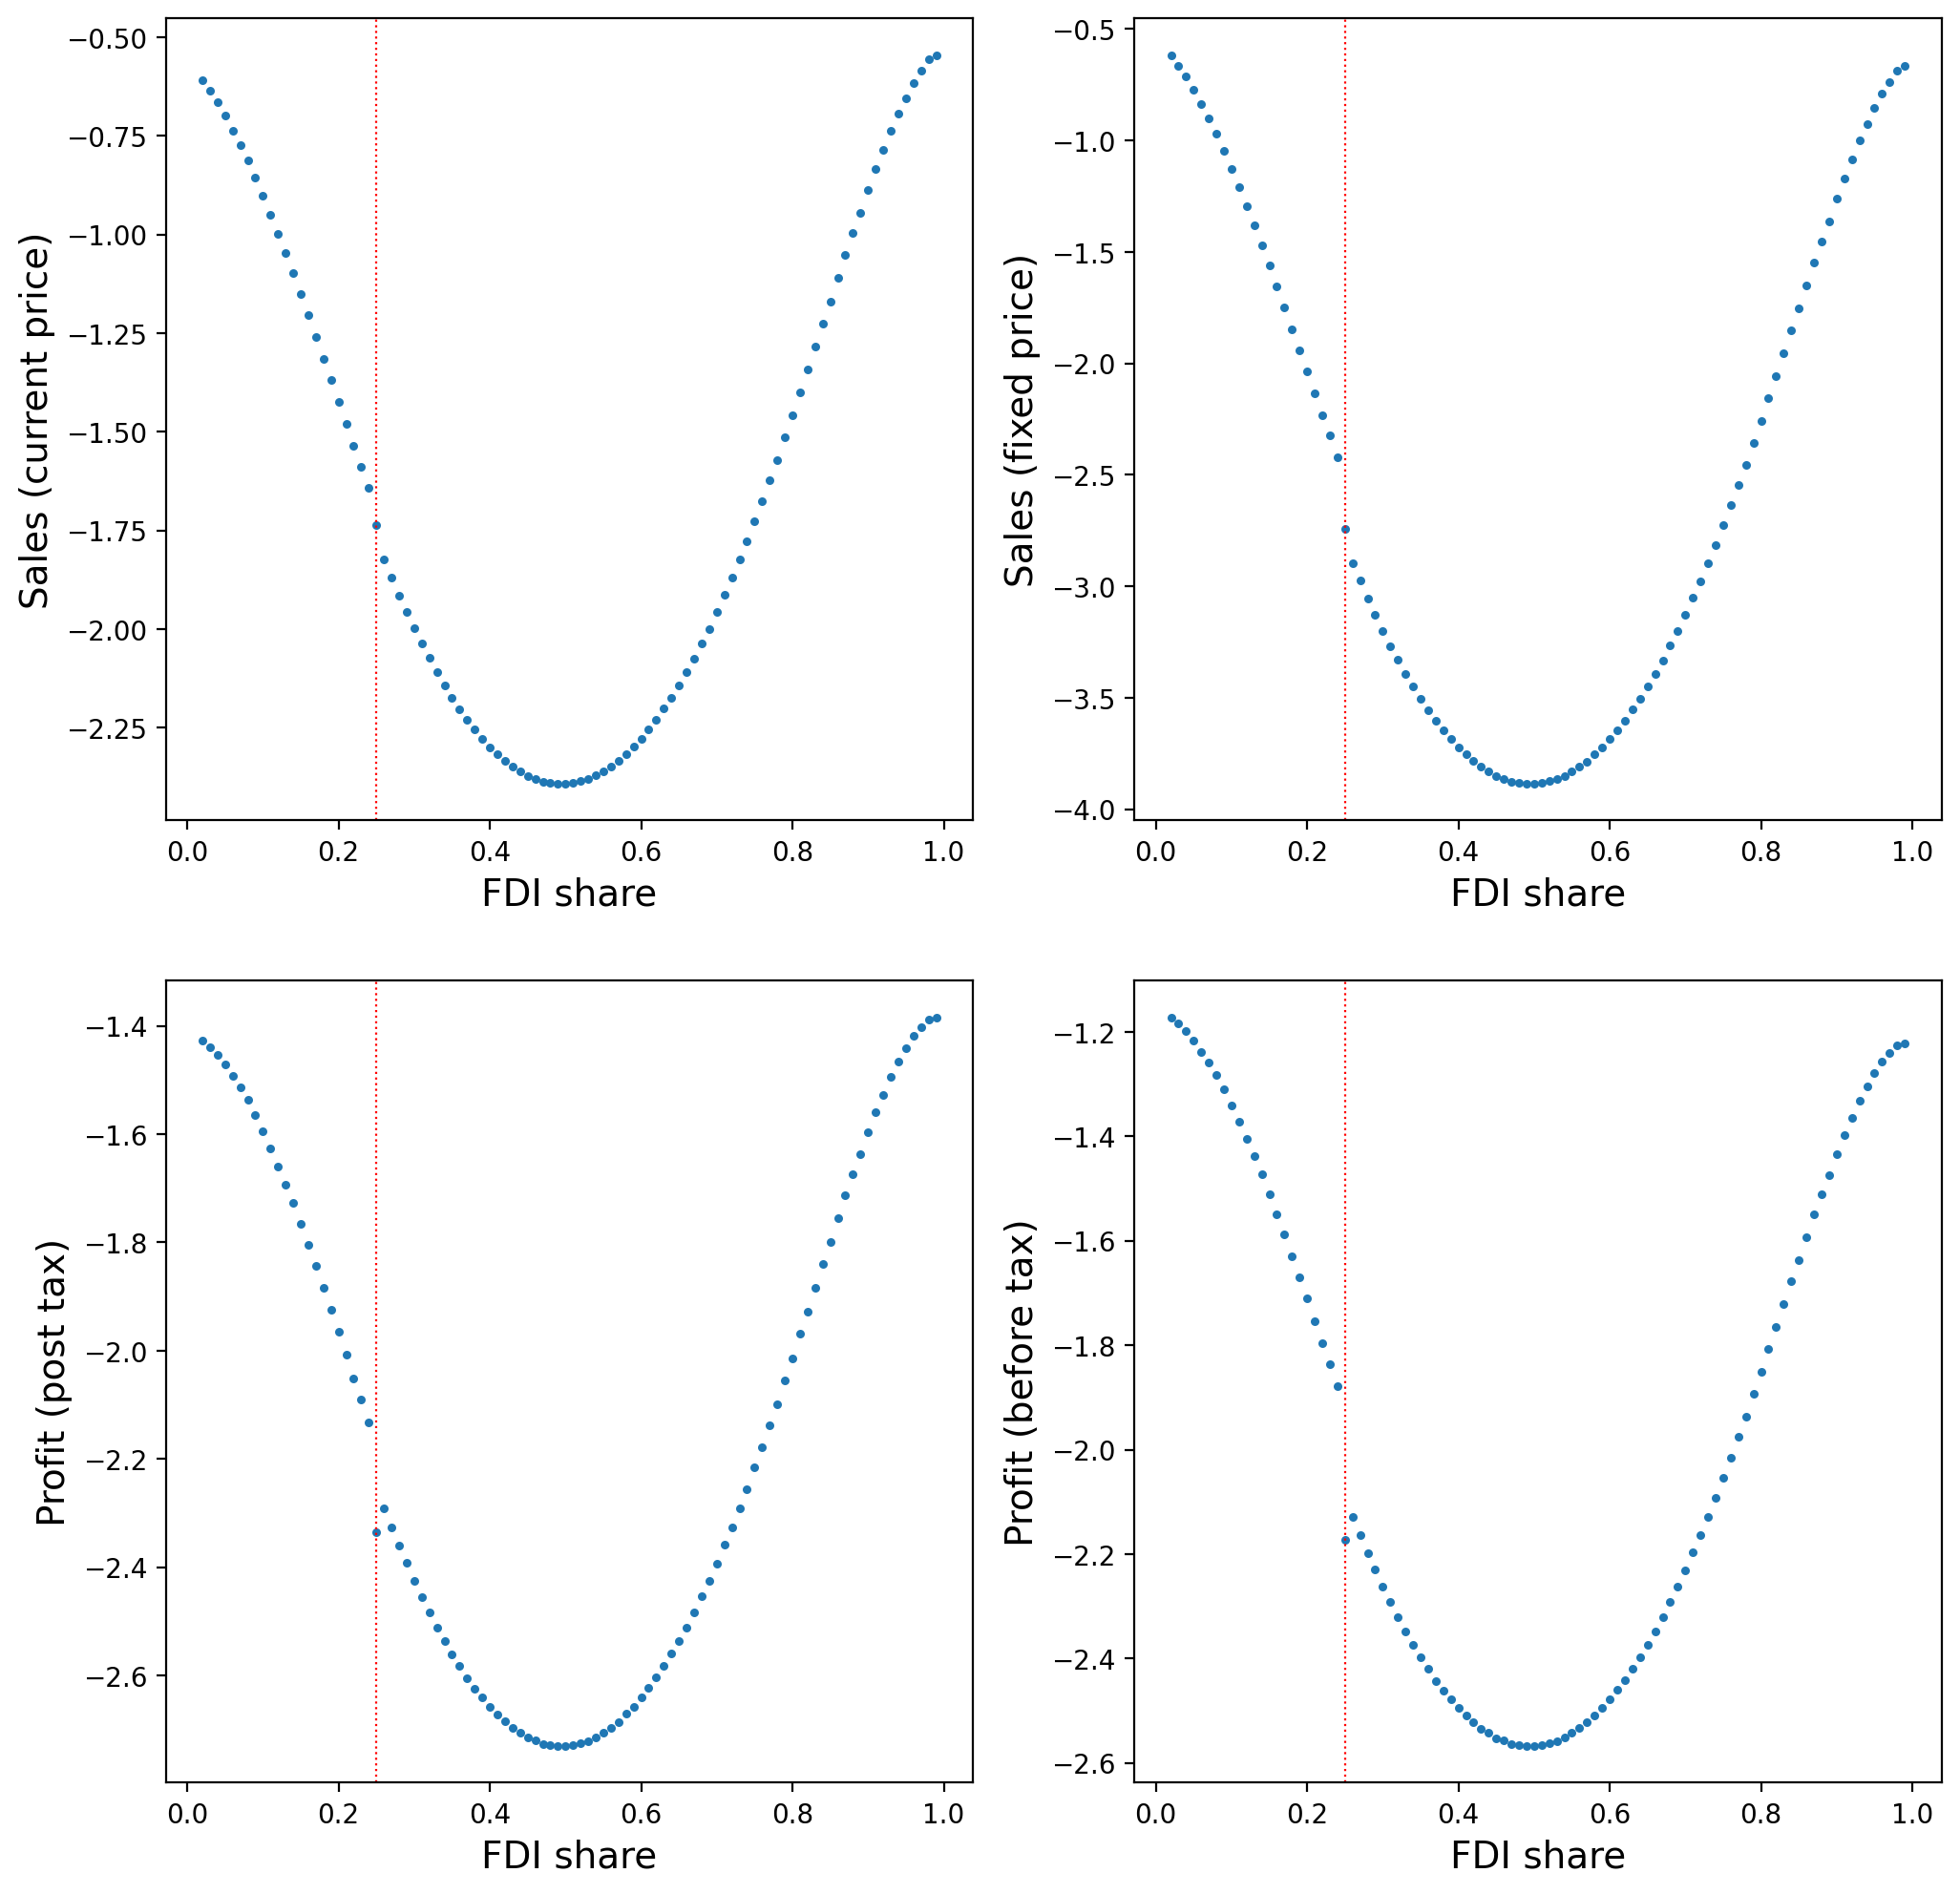

In [29]:
fig_bins = np.arange(2,100)/100
fig_meanOutcomesSimul, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,12), dpi=200)
ax1.scatter(fig_bins, OutcomeRst[:,0], s=5)
ax1.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax1.set_ylabel('Sales (current price)', fontsize = 14.0) 
ax1.set_xlabel('FDI share', fontsize = 14.0) 

ax2.scatter(fig_bins, OutcomeRst[:,1], s=5)
ax2.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax2.set_ylabel('Sales (fixed price)', fontsize = 14.0) 
ax2.set_xlabel('FDI share', fontsize = 14.0) 

ax3.scatter(fig_bins, OutcomeRst[:,2], s=5)
ax3.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax3.set_ylabel('Profit (post tax)', fontsize = 14.0) 
ax3.set_xlabel('FDI share', fontsize = 14.0) 

ax4.scatter(fig_bins, OutcomeRst[:,3], s=5)
ax4.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax4.set_ylabel('Profit (before tax)', fontsize = 14.0) 
ax4.set_xlabel('FDI share', fontsize = 14.0) 


Text(0.5, 0, 'FDI share')

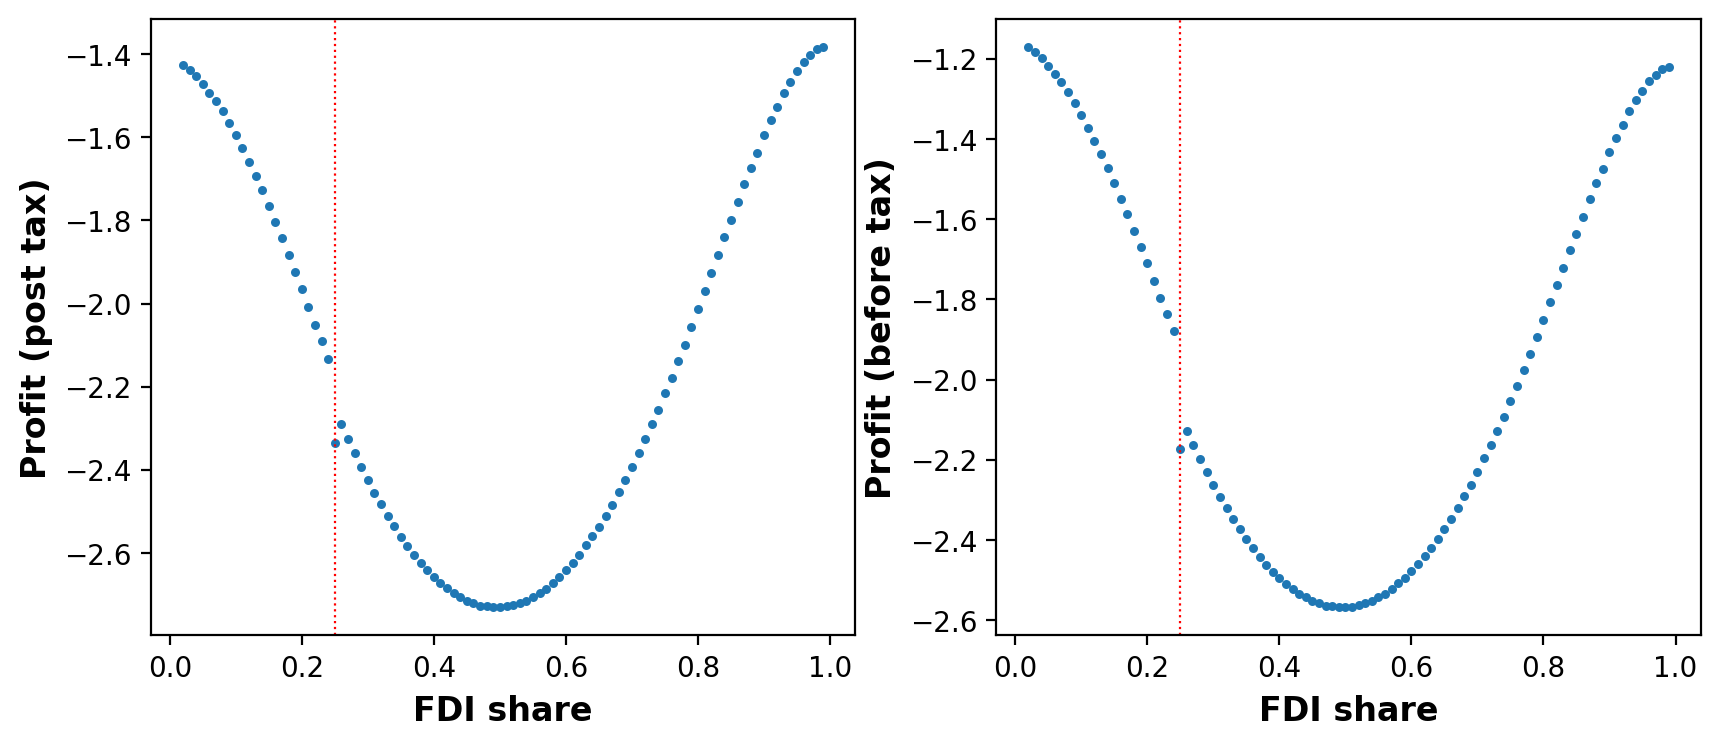

In [48]:
fig_bins = np.arange(2,100)/100
fig_meanOutcomesSimul,  (ax3, ax4) = plt.subplots(1,2, figsize=(10,4), dpi=200)

ax3.scatter(fig_bins, OutcomeRst[:,2], s=5)
ax3.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax3.set_ylabel('Profit (post tax)', fontsize = 12.0, fontweight='bold') 
ax3.set_xlabel('FDI share', fontsize = 12.0, fontweight='bold') 

ax4.scatter(fig_bins, OutcomeRst[:,3], s=5)
ax4.axvline(x=0.25, c='r', linewidth=0.8, linestyle=':')
ax4.set_ylabel('Profit (before tax)', fontsize = 12.0, fontweight='bold') 
ax4.set_xlabel('FDI share', fontsize = 12.0, fontweight='bold') 


In [49]:
fig_meanOutcomesSimul.savefig(figure_path+'meanOutcomesSimulJune172023.pdf')